# Life Expectancy Classification Model

This notebook focuses on implementing classification models for the life expectancy dataset. We'll convert the continuous life expectancy variable into categorical classes and train various classification algorithms to predict these classes.

## Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('default')
sns.set_palette('viridis')
%matplotlib inline

# Display all columns
pd.set_option('display.max_columns', None)

## Load and Prepare the Dataset

In [2]:
# Load the original dataset
df = pd.read_csv('./resources/Life Expectancy Data.csv')
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# Check basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

Population                         652
Hepatitis B                        553
GDP                                448
Total expenditure                  226
Alcohol                            194
Income composition of resources    167
Schooling                          163
 BMI                                34
 thinness  1-19 years               34
 thinness 5-9 years                 34
Polio                               19
Diphtheria                          19
Life expectancy                     10
Adult Mortality                     10
dtype: int64

In [5]:
# Handle missing values
# For numerical columns, use median imputation
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, use mode imputation
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify no missing values remain
print(f"Missing values after imputation: {df.isnull().sum().sum()}")

Missing values after imputation: 0


## Convert Life Expectancy to Classes

We'll convert the continuous life expectancy variable into categorical classes for classification. We'll create three classes:
1. Low life expectancy
2. Medium life expectancy
3. High life expectancy

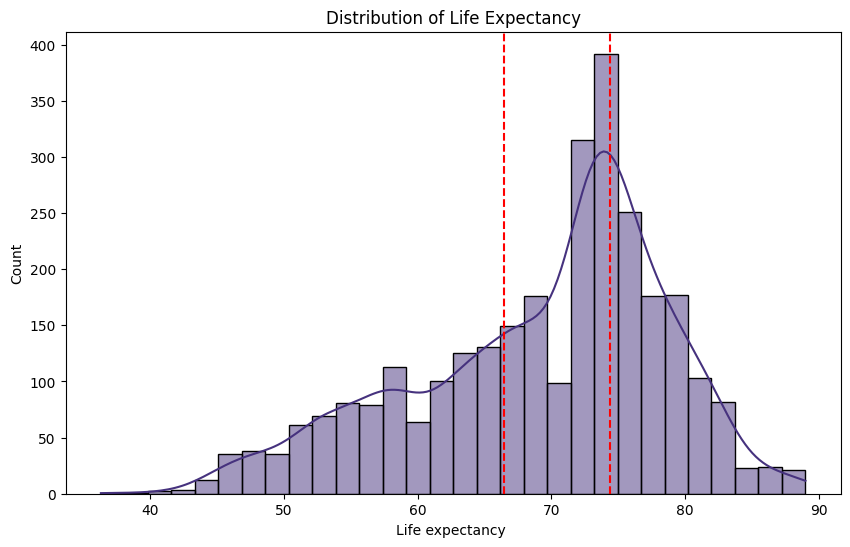

33rd percentile: 66.42
67th percentile: 74.40


In [6]:
# Examine the distribution of life expectancy
plt.figure(figsize=(10, 6))
sns.histplot(df['Life expectancy '], bins=30, kde=True)
plt.title('Distribution of Life Expectancy')
plt.axvline(df['Life expectancy '].quantile(0.33), color='r', linestyle='--')
plt.axvline(df['Life expectancy '].quantile(0.67), color='r', linestyle='--')
plt.show()

# Display quantiles
print(f"33rd percentile: {df['Life expectancy '].quantile(0.33):.2f}")
print(f"67th percentile: {df['Life expectancy '].quantile(0.67):.2f}")

In [7]:
# Create life expectancy classes
def categorize_life_expectancy(value):
    low_threshold = df['Life expectancy '].quantile(0.33)
    high_threshold = df['Life expectancy '].quantile(0.67)
    
    if value < low_threshold:
        return 0  # Low life expectancy
    elif value < high_threshold:
        return 1  # Medium life expectancy
    else:
        return 2  # High life expectancy

# Apply the function to create a new target variable
df['Life_Expectancy_Class'] = df['Life expectancy '].apply(categorize_life_expectancy)

# Map numeric classes to labels for better interpretability
class_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
df['Life_Expectancy_Label'] = df['Life_Expectancy_Class'].map(class_mapping)

# Check the distribution of classes
print(df['Life_Expectancy_Label'].value_counts())
print(df['Life_Expectancy_Class'].value_counts())

Life_Expectancy_Label
High      989
Medium    979
Low       970
Name: count, dtype: int64
Life_Expectancy_Class
2    989
1    979
0    970
Name: count, dtype: int64


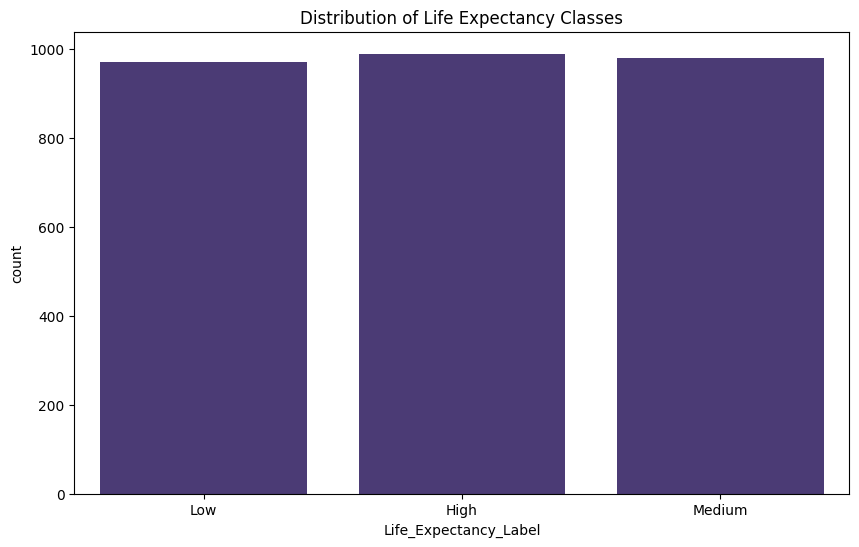

In [8]:
# Visualize the distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(x='Life_Expectancy_Label', data=df)
plt.title('Distribution of Life Expectancy Classes')
plt.show()

## Prepare Features and Target for Classification

In [9]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Status', 'Country'], drop_first=True)

# Define features and target
X = df_encoded.drop(['Life expectancy ', 'Life_Expectancy_Class', 'Life_Expectancy_Label', 'Year'], axis=1)
y = df_encoded['Life_Expectancy_Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2350, 211)
X_test shape: (588, 211)
y_train shape: (2350,)
y_test shape: (588,)


## Define Evaluation Metrics

We'll use multiple metrics to evaluate our classification models:
1. Accuracy: Overall correctness of the model
2. Precision: Ability of the model to avoid false positives
3. Recall: Ability of the model to find all positive samples
4. F1-score: Harmonic mean of precision and recall
5. ROC-AUC: Area under the ROC curve (for multi-class, we'll use one-vs-rest approach)

In [12]:
# Function to evaluate a classification model
def evaluate_classification_model(model, X_train, X_test, y_train, y_test, class_names=['Low', 'Medium', 'High']):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # For multi-class, we use weighted averages
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # For ROC-AUC in multi-class, we use one-vs-rest approach if the model supports predict_proba
    if hasattr(model, "predict_proba"):
        try:
            y_test_proba = model.predict_proba(X_test)
            test_roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
        except:
            test_roc_auc = None
    else:
        test_roc_auc = None
    
    # Return metrics as a dictionary
    metrics = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train Precision': train_precision,
        'Test Precision': test_precision,
        'Train Recall': train_recall,
        'Test Recall': test_recall,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Test ROC-AUC': test_roc_auc
    }
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=class_names))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return metrics

## Train Baseline Classification Models

We'll train several baseline classification models to establish a performance benchmark.


Training Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.95      0.95       194
      Medium       0.88      0.87      0.87       196
        High       0.92      0.92      0.92       198

    accuracy                           0.92       588
   macro avg       0.92      0.92      0.92       588
weighted avg       0.92      0.92      0.92       588



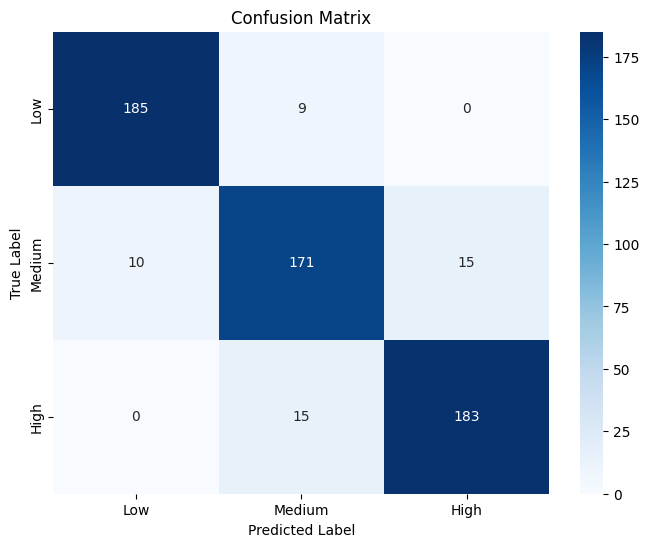

  Test Accuracy: 0.9167, Test F1: 0.9166, Time: 0.14s

Training Decision Tree...

Classification Report:
              precision    recall  f1-score   support

         Low       0.93      0.92      0.93       194
      Medium       0.83      0.82      0.83       196
        High       0.89      0.91      0.90       198

    accuracy                           0.88       588
   macro avg       0.88      0.88      0.88       588
weighted avg       0.88      0.88      0.88       588



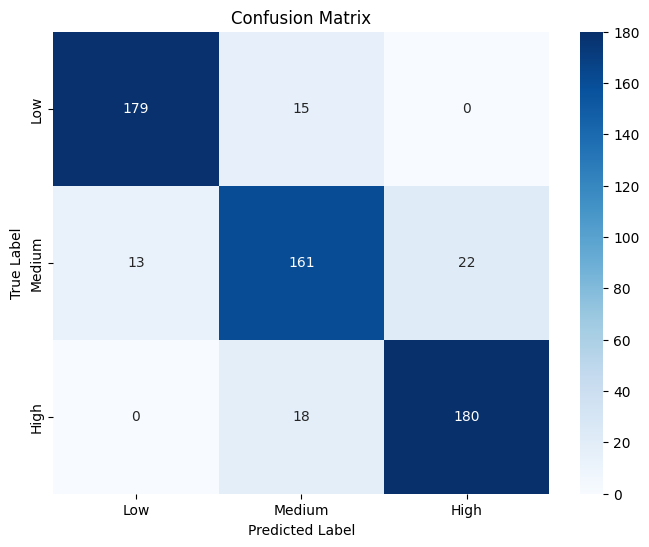

  Test Accuracy: 0.8844, Test F1: 0.8843, Time: 0.13s

Training Random Forest...

Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.97      0.96       194
      Medium       0.91      0.91      0.91       196
        High       0.96      0.93      0.95       198

    accuracy                           0.94       588
   macro avg       0.94      0.94      0.94       588
weighted avg       0.94      0.94      0.94       588



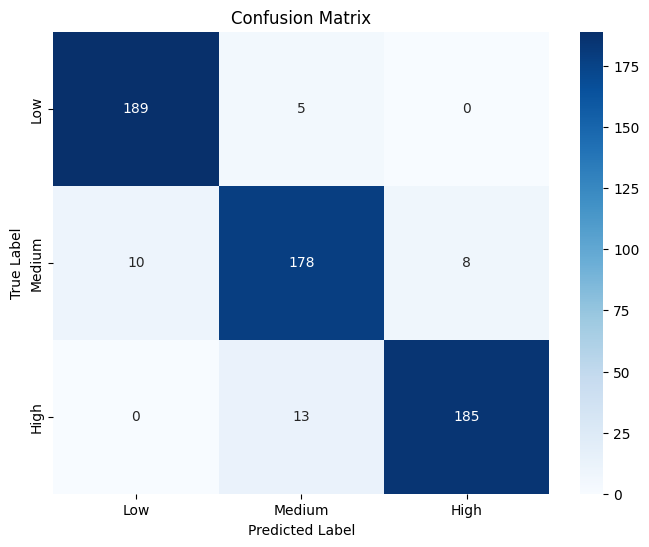

  Test Accuracy: 0.9388, Test F1: 0.9387, Time: 0.40s

Training Gradient Boosting...

Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.95      0.95       194
      Medium       0.88      0.89      0.88       196
        High       0.94      0.92      0.93       198

    accuracy                           0.92       588
   macro avg       0.92      0.92      0.92       588
weighted avg       0.92      0.92      0.92       588



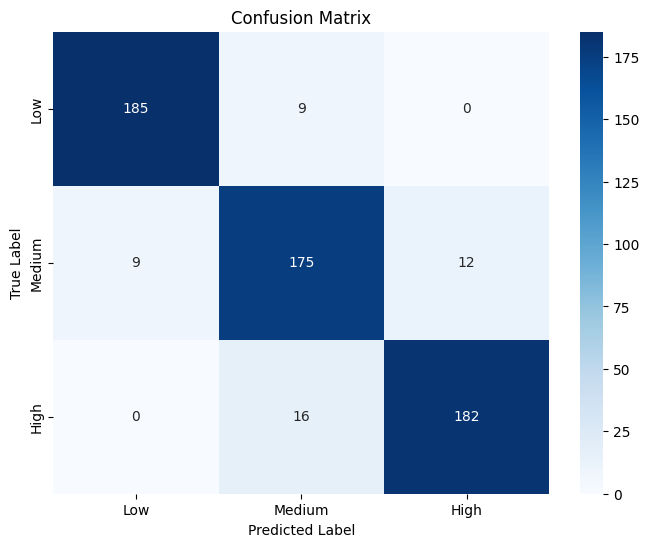

  Test Accuracy: 0.9218, Test F1: 0.9219, Time: 2.57s

Training AdaBoost...

Classification Report:
              precision    recall  f1-score   support

         Low       0.93      0.90      0.91       194
      Medium       0.74      0.59      0.66       196
        High       0.73      0.89      0.80       198

    accuracy                           0.79       588
   macro avg       0.80      0.79      0.79       588
weighted avg       0.80      0.79      0.79       588



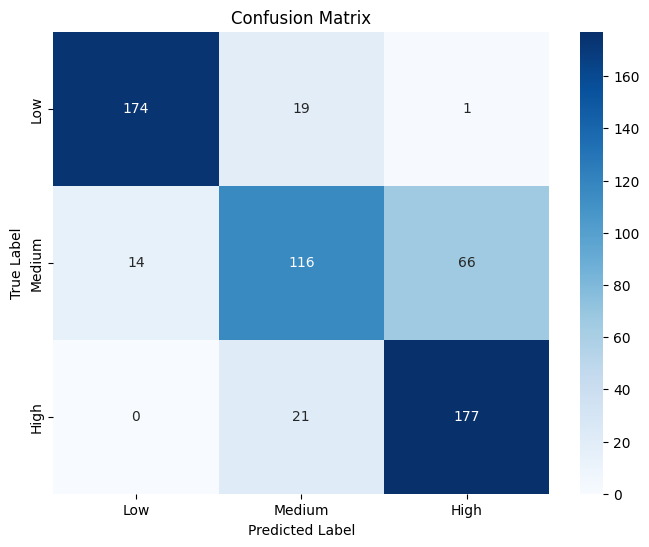

  Test Accuracy: 0.7942, Test F1: 0.7900, Time: 0.42s

Training SVM...

Classification Report:
              precision    recall  f1-score   support

         Low       0.90      0.92      0.91       194
      Medium       0.78      0.79      0.78       196
        High       0.88      0.85      0.87       198

    accuracy                           0.85       588
   macro avg       0.85      0.85      0.85       588
weighted avg       0.85      0.85      0.85       588



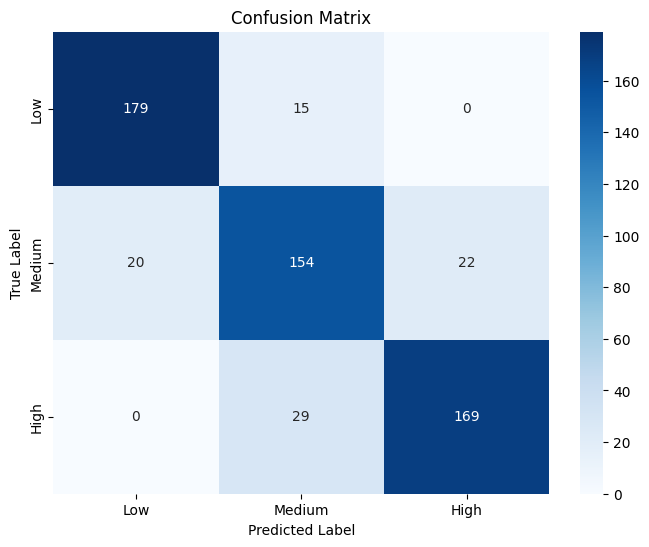

  Test Accuracy: 0.8537, Test F1: 0.8537, Time: 1.00s

Training K-Nearest Neighbors...

Classification Report:
              precision    recall  f1-score   support

         Low       0.91      0.94      0.92       194
      Medium       0.82      0.81      0.81       196
        High       0.90      0.89      0.90       198

    accuracy                           0.88       588
   macro avg       0.88      0.88      0.88       588
weighted avg       0.88      0.88      0.88       588



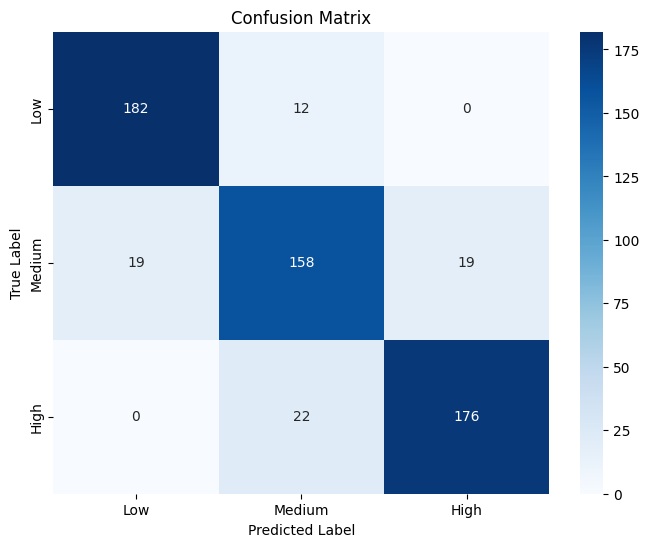

  Test Accuracy: 0.8776, Test F1: 0.8771, Time: 0.24s

Training Naive Bayes...

Classification Report:
              precision    recall  f1-score   support

         Low       0.82      1.00      0.90       194
      Medium       0.85      0.59      0.70       196
        High       0.82      0.90      0.86       198

    accuracy                           0.83       588
   macro avg       0.83      0.83      0.82       588
weighted avg       0.83      0.83      0.82       588



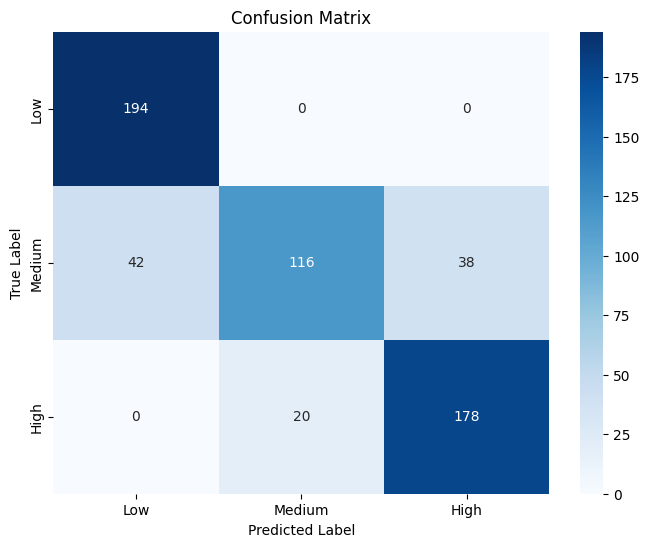

  Test Accuracy: 0.8299, Test F1: 0.8202, Time: 0.10s

Training Neural Network...

Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.93      0.94       194
      Medium       0.86      0.89      0.87       196
        High       0.94      0.92      0.93       198

    accuracy                           0.91       588
   macro avg       0.92      0.91      0.92       588
weighted avg       0.92      0.91      0.92       588



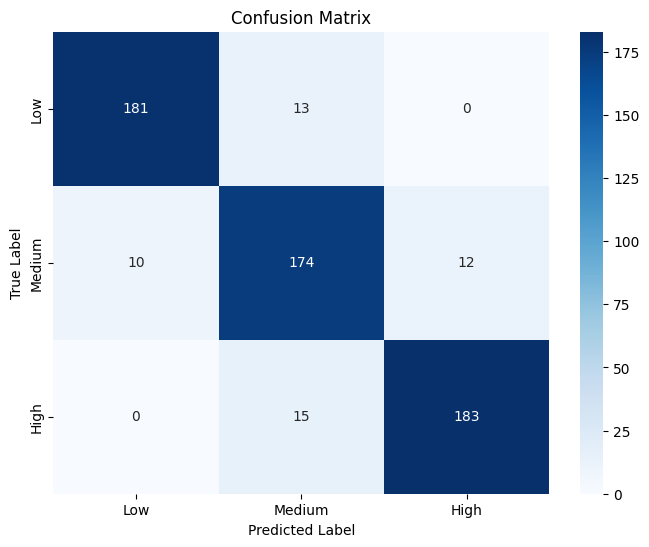

  Test Accuracy: 0.9150, Test F1: 0.9153, Time: 3.98s


In [13]:
# Define baseline classification models
baseline_classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42)
}

# Train and evaluate baseline models
baseline_results = {}
for name, model in baseline_classifiers.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Evaluate the model
    metrics = evaluate_classification_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Add training time
    training_time = time.time() - start_time
    metrics['Training Time (s)'] = training_time
    
    # Store results
    baseline_results[name] = metrics
    
    print(f"  Test Accuracy: {metrics['Test Accuracy']:.4f}, Test F1: {metrics['Test F1']:.4f}, Time: {training_time:.2f}s")

In [14]:
# Convert baseline results to DataFrame
baseline_df = pd.DataFrame(baseline_results).T

# Sort by Test Accuracy in descending order
baseline_df = baseline_df.sort_values('Test Accuracy', ascending=False)

# Display baseline results
baseline_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Test ROC-AUC,Training Time (s)
Random Forest,1.000000,0.938776,1.000000,0.938850,1.000000,0.938776,1.000000,0.938709,0.982635,0.396320
Gradient Boosting,0.960000,0.921769,0.960580,0.922198,0.960000,0.921769,0.960028,0.921921,0.975752,2.567447
Logistic Regression,0.934894,0.916667,0.936647,0.916545,0.934894,0.916667,0.935137,0.916602,0.977365,0.137166
Neural Network,0.988085,0.914966,0.988211,0.915799,0.988085,0.914966,0.988092,0.915279,0.975537,3.979889
Decision Tree,1.000000,0.884354,1.000000,0.884286,1.000000,0.884354,1.000000,0.884274,0.913269,0.126494
K-Nearest Neighbors,0.927234,0.877551,0.928517,0.876975,0.927234,0.877551,0.927328,0.877121,0.958687,0.238590
SVM,0.896170,0.853741,0.899716,0.853981,0.896170,0.853741,0.896393,0.853711,0.954741,1.001550
Naive Bayes,0.842128,0.829932,0.845753,0.833023,0.842128,0.829932,0.834422,0.820197,0.940495,0.102532
AdaBoost,0.783404,0.794218,0.791153,0.797496,0.783404,0.794218,0.782490,0.789956,0.776598,0.415217


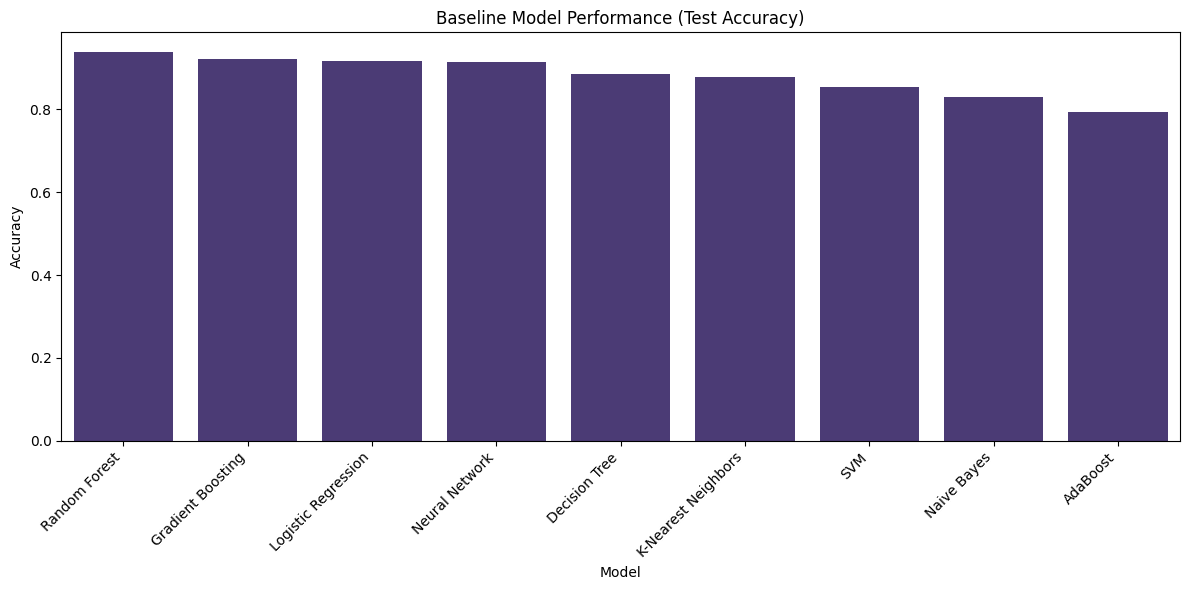

In [15]:
# Visualize baseline model performance (Test Accuracy)
plt.figure(figsize=(12, 6))
sns.barplot(x=baseline_df.index, y=baseline_df['Test Accuracy'])
plt.title('Baseline Model Performance (Test Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

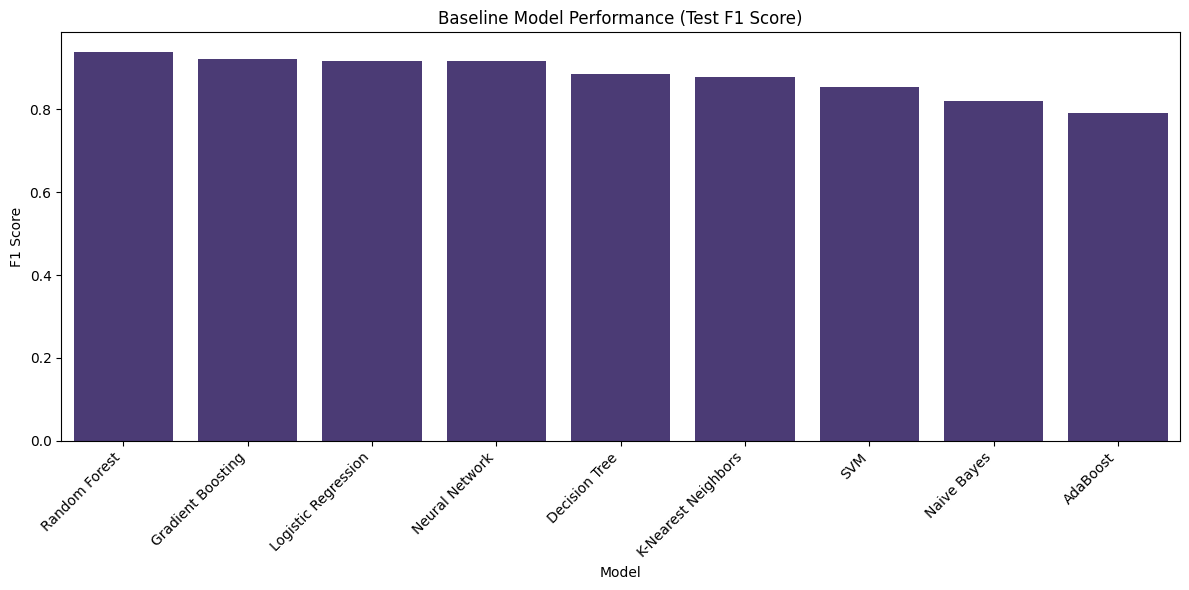

In [16]:
# Visualize baseline model performance (Test F1 Score)
plt.figure(figsize=(12, 6))
sns.barplot(x=baseline_df.index, y=baseline_df['Test F1'])
plt.title('Baseline Model Performance (Test F1 Score)')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Select Top Performing Models for Hyperparameter Tuning

Based on the baseline results, we'll select the top performing models for hyperparameter tuning.

In [17]:
# Select top 3 models based on Test Accuracy
top_models = baseline_df.head(3).index.tolist()
print(f"Top performing models: {top_models}")

Top performing models: ['Random Forest', 'Gradient Boosting', 'Logistic Regression']


## Hyperparameter Tuning for Top Models

We'll use RandomizedSearchCV to tune the hyperparameters of our top performing models.

In [19]:
# Define hyperparameter grids for each model
param_grids = {}

# Random Forest
if 'Random Forest' in top_models:
    param_grids['Random Forest'] = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

# Gradient Boosting
if 'Gradient Boosting' in top_models:
    param_grids['Gradient Boosting'] = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0]
    }

# SVM
if 'SVM' in top_models:
    param_grids['SVM'] = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }

# Logistic Regression
if 'Logistic Regression' in top_models:
    param_grids['Logistic Regression'] = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [1000, 2000, 3000]
    }

# K-Nearest Neighbors
if 'K-Nearest Neighbors' in top_models:
    param_grids['K-Nearest Neighbors'] = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2]
    }

# Neural Network
if 'Neural Network' in top_models:
    param_grids['Neural Network'] = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'sgd', 'lbfgs'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive', 'invscaling']
    }

# Decision Tree
if 'Decision Tree' in top_models:
    param_grids['Decision Tree'] = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

# AdaBoost
if 'AdaBoost' in top_models:
    param_grids['AdaBoost'] = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    }

# Naive Bayes
if 'Naive Bayes' in top_models:
    param_grids['Naive Bayes'] = {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    }


Tuning Random Forest...

Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.98      0.96       194
      Medium       0.90      0.90      0.90       196
        High       0.95      0.92      0.93       198

    accuracy                           0.93       588
   macro avg       0.93      0.93      0.93       588
weighted avg       0.93      0.93      0.93       588



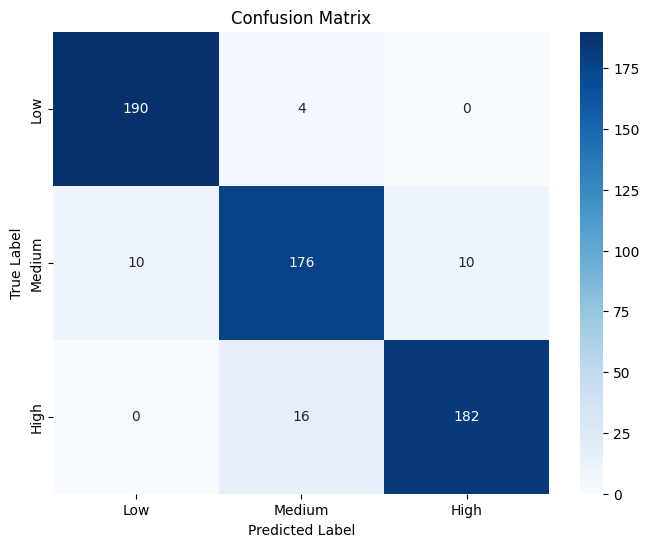

  Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
  Test Accuracy: 0.9320, Test F1: 0.9318, Time: 6.51s

Tuning Gradient Boosting...

Classification Report:
              precision    recall  f1-score   support

         Low       0.96      0.97      0.96       194
      Medium       0.91      0.91      0.91       196
        High       0.95      0.94      0.94       198

    accuracy                           0.94       588
   macro avg       0.94      0.94      0.94       588
weighted avg       0.94      0.94      0.94       588



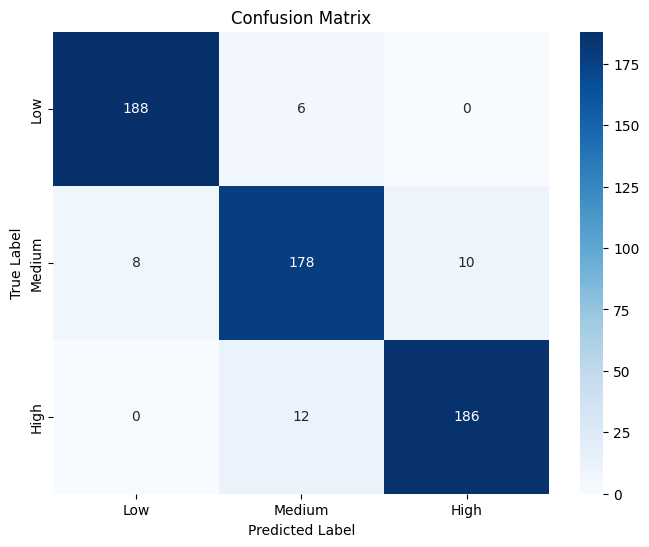

  Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.05}
  Test Accuracy: 0.9388, Test F1: 0.9387, Time: 51.86s

Tuning Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

         Low       0.94      0.96      0.95       194
      Medium       0.89      0.87      0.88       196
        High       0.92      0.92      0.92       198

    accuracy                           0.92       588
   macro avg       0.92      0.92      0.92       588
weighted avg       0.92      0.92      0.92       588



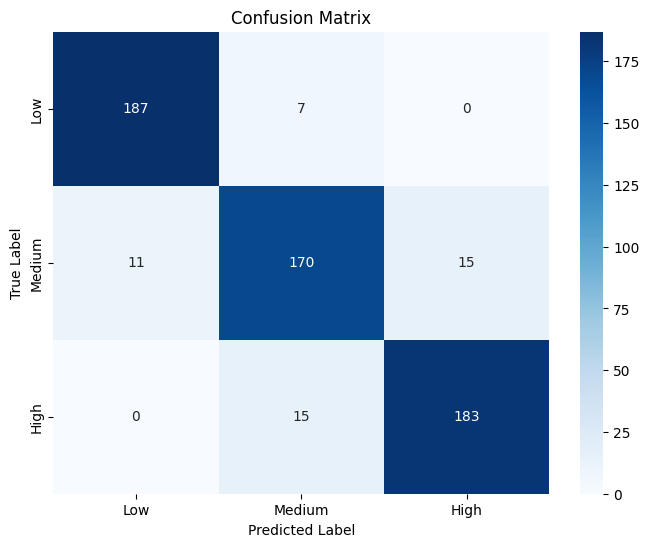

  Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 3000, 'C': 1}
  Test Accuracy: 0.9184, Test F1: 0.9181, Time: 40.84s


In [20]:
# Perform hyperparameter tuning for top models
tuned_models = {}
tuned_results = {}

for name in top_models:
    print(f"\nTuning {name}...")
    start_time = time.time()
    
    # Get the model and parameter grid
    model = baseline_classifiers[name]
    param_grid = param_grids[name]
    
    # Create RandomizedSearchCV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,
        scoring='accuracy',
        cv=cv,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit RandomizedSearchCV
    random_search.fit(X_train_scaled, y_train)
    
    # Get best model
    best_model = random_search.best_estimator_
    tuned_models[name] = best_model
    
    # Evaluate best model
    metrics = evaluate_classification_model(best_model, X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Add training time and best parameters
    training_time = time.time() - start_time
    metrics['Training Time (s)'] = training_time
    metrics['Best Parameters'] = random_search.best_params_
    
    # Store results
    tuned_results[name] = metrics
    
    print(f"  Best parameters: {random_search.best_params_}")
    print(f"  Test Accuracy: {metrics['Test Accuracy']:.4f}, Test F1: {metrics['Test F1']:.4f}, Time: {training_time:.2f}s")

In [21]:
# Convert tuned results to DataFrame (excluding Best Parameters)
tuned_df = pd.DataFrame({k: {k2: v2 for k2, v2 in v.items() if k2 != 'Best Parameters'} 
                         for k, v in tuned_results.items()}).T

# Sort by Test Accuracy in descending order
tuned_df = tuned_df.sort_values('Test Accuracy', ascending=False)

# Display tuned results
tuned_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Test ROC-AUC,Training Time (s)
Gradient Boosting,1.000000,0.938776,1.000000,0.938741,1.000000,0.938776,1.00000,0.938742,0.981539,51.864161
Random Forest,1.000000,0.931973,1.000000,0.931952,1.000000,0.931973,1.00000,0.931814,0.982938,6.506619
Logistic Regression,0.935319,0.918367,0.936972,0.917966,0.935319,0.918367,0.93555,0.918103,0.978177,40.839597


In [22]:
# Compare baseline and tuned models
comparison_data = []
for model_name in top_models:
    baseline_accuracy = baseline_results[model_name]['Test Accuracy']
    tuned_accuracy = tuned_results[model_name]['Test Accuracy']
    baseline_f1 = baseline_results[model_name]['Test F1']
    tuned_f1 = tuned_results[model_name]['Test F1']
    
    comparison_data.append({
        'Model': model_name,
        'Metric': 'Accuracy',
        'Baseline': baseline_accuracy,
        'Tuned': tuned_accuracy,
        'Improvement': tuned_accuracy - baseline_accuracy
    })
    
    comparison_data.append({
        'Model': model_name,
        'Metric': 'F1 Score',
        'Baseline': baseline_f1,
        'Tuned': tuned_f1,
        'Improvement': tuned_f1 - baseline_f1
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Model,Metric,Baseline,Tuned,Improvement
0,Random Forest,Accuracy,0.938776,0.931973,-0.006803
1,Random Forest,F1 Score,0.938709,0.931814,-0.006895
2,Gradient Boosting,Accuracy,0.921769,0.938776,0.017007
3,Gradient Boosting,F1 Score,0.921921,0.938742,0.016821
4,Logistic Regression,Accuracy,0.916667,0.918367,0.001701
5,Logistic Regression,F1 Score,0.916602,0.918103,0.001501


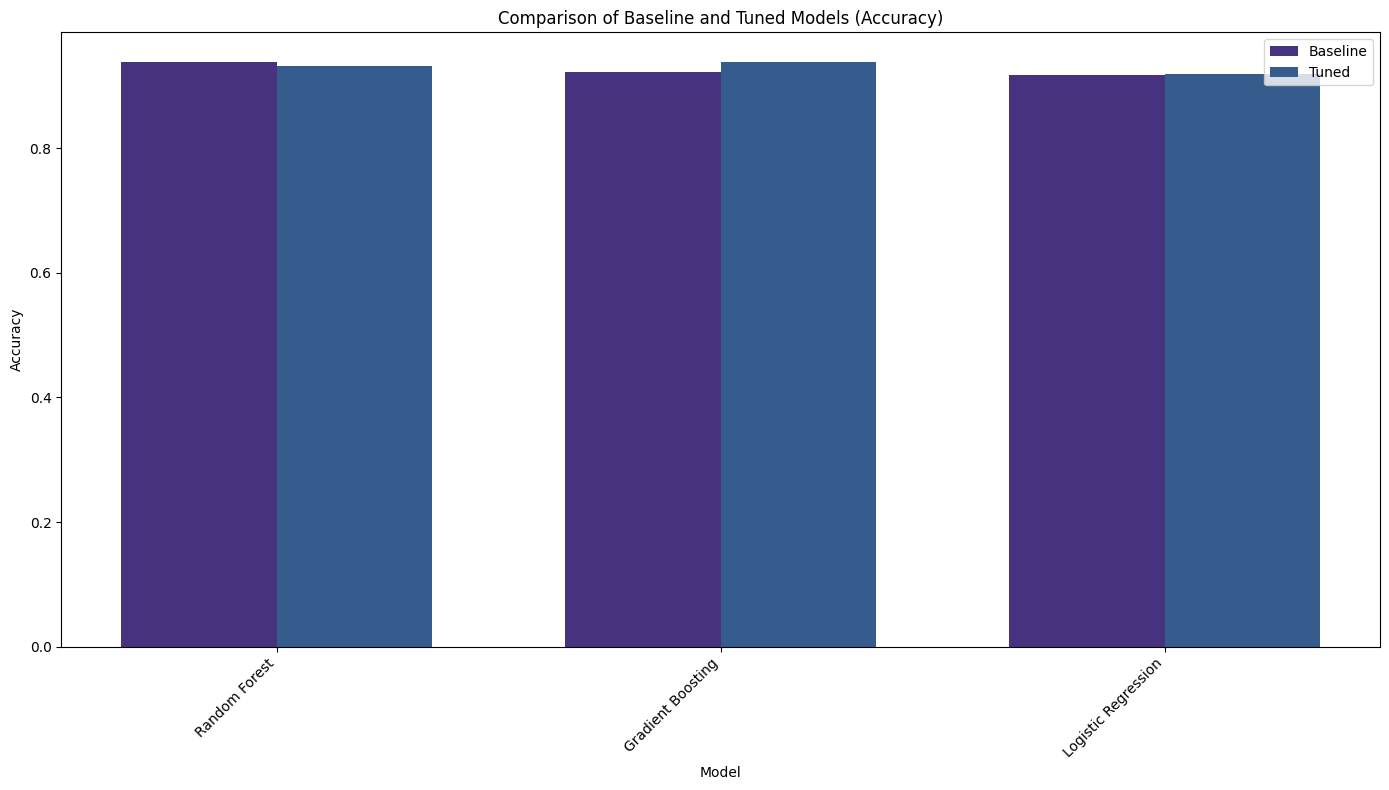

In [23]:
# Visualize comparison between baseline and tuned models
plt.figure(figsize=(14, 8))

# Filter for Accuracy metric
accuracy_df = comparison_df[comparison_df['Metric'] == 'Accuracy']

# Create grouped bar chart
x = np.arange(len(accuracy_df))
width = 0.35

plt.bar(x - width/2, accuracy_df['Baseline'], width, label='Baseline')
plt.bar(x + width/2, accuracy_df['Tuned'], width, label='Tuned')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Baseline and Tuned Models (Accuracy)')
plt.xticks(x, accuracy_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

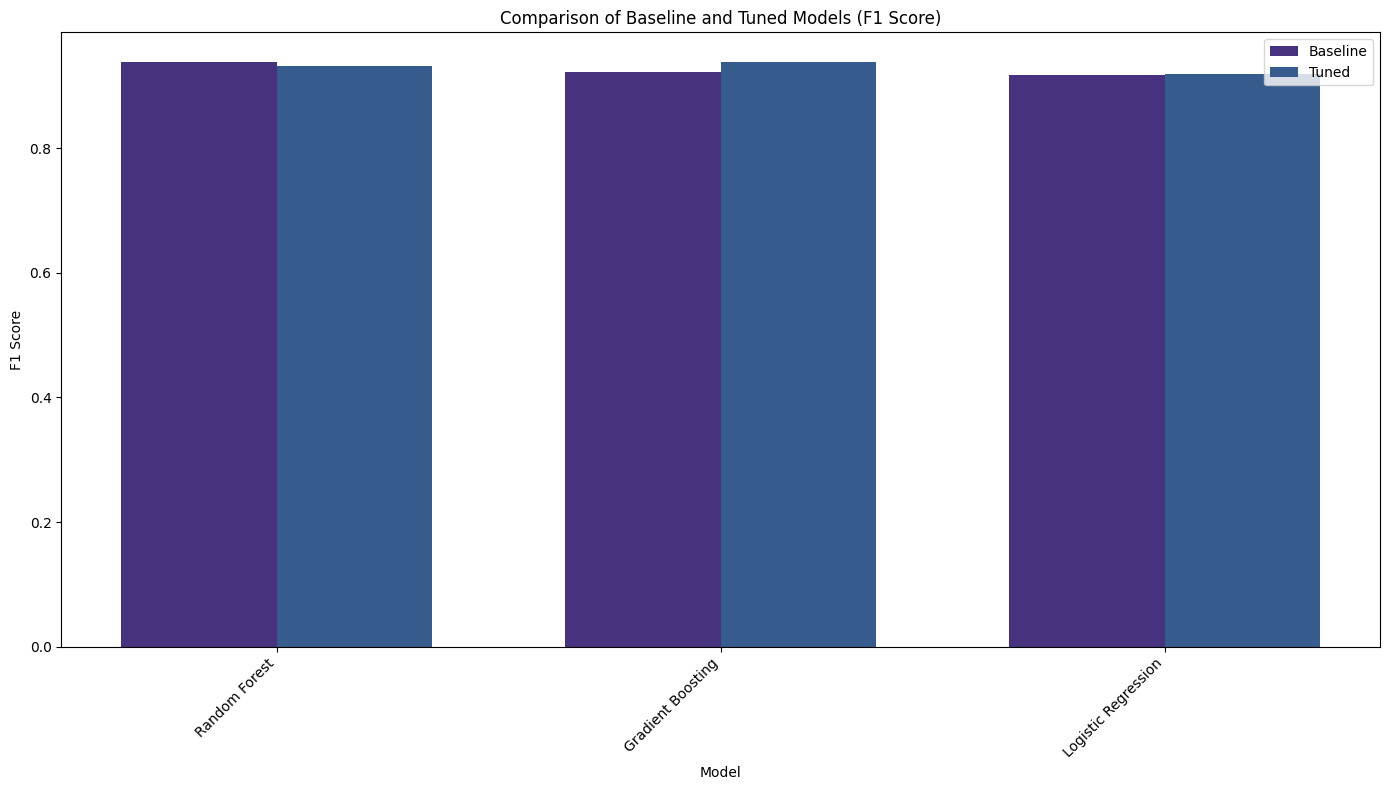

In [24]:
# Visualize comparison between baseline and tuned models for F1 Score
plt.figure(figsize=(14, 8))

# Filter for F1 Score metric
f1_df = comparison_df[comparison_df['Metric'] == 'F1 Score']

# Create grouped bar chart
x = np.arange(len(f1_df))
width = 0.35

plt.bar(x - width/2, f1_df['Baseline'], width, label='Baseline')
plt.bar(x + width/2, f1_df['Tuned'], width, label='Tuned')

plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of Baseline and Tuned Models (F1 Score)')
plt.xticks(x, f1_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Identify the Best Classification Model

Based on the tuned results, we'll identify the best classification model.

In [25]:
# Get the best model based on Test Accuracy
best_model_name = tuned_df.index[0]
best_model = tuned_models[best_model_name]

print(f"Best classification model: {best_model_name}")
print(f"Test Accuracy: {tuned_df.loc[best_model_name, 'Test Accuracy']:.4f}")
print(f"Test F1 Score: {tuned_df.loc[best_model_name, 'Test F1']:.4f}")
print(f"Test Precision: {tuned_df.loc[best_model_name, 'Test Precision']:.4f}")
print(f"Test Recall: {tuned_df.loc[best_model_name, 'Test Recall']:.4f}")
if tuned_df.loc[best_model_name, 'Test ROC-AUC'] is not None:
    print(f"Test ROC-AUC: {tuned_df.loc[best_model_name, 'Test ROC-AUC']:.4f}")

Best classification model: Gradient Boosting
Test Accuracy: 0.9388
Test F1 Score: 0.9387
Test Precision: 0.9387
Test Recall: 0.9388
Test ROC-AUC: 0.9815


## Detailed Analysis of the Best Model

In [26]:
# Get predictions from the best model
y_pred = best_model.predict(X_test_scaled)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Map numeric classes to labels
results_df['Actual_Label'] = results_df['Actual'].map(class_mapping)
results_df['Predicted_Label'] = results_df['Predicted'].map(class_mapping)

# Check if predictions match
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

# Display a sample of the results
results_df.sample(10)

,Actual,Predicted,Actual_Label,Predicted_Label,Correct
620,0,0,Low,Low,True
1335,1,1,Medium,Medium,True
381,2,2,High,High,True
2471,0,0,Low,Low,True
2748,2,2,High,High,True
2434,2,2,High,High,True
1816,1,1,Medium,Medium,True
242,2,2,High,High,True
178,2,2,High,High,True
418,0,0,Low,Low,True


In [27]:
# Analyze prediction accuracy by class
class_accuracy = results_df.groupby('Actual_Label')['Correct'].mean()
print("Accuracy by class:")
print(class_accuracy)

Accuracy by class:
Actual_Label
High      0.939394
Low       0.969072
Medium    0.908163
Name: Correct, dtype: float64


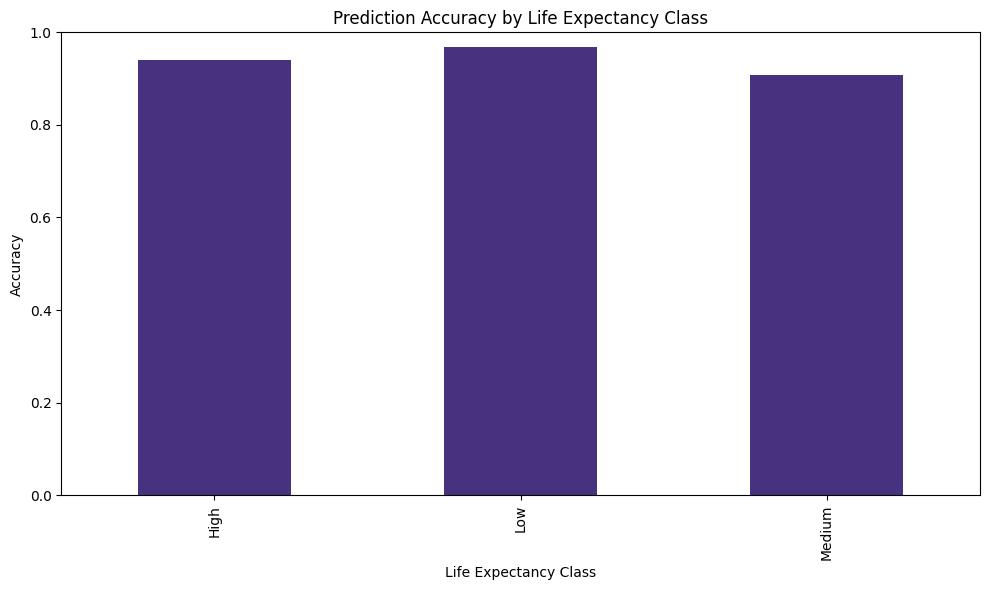

In [28]:
# Visualize accuracy by class
plt.figure(figsize=(10, 6))
class_accuracy.plot(kind='bar')
plt.title('Prediction Accuracy by Life Expectancy Class')
plt.ylabel('Accuracy')
plt.xlabel('Life Expectancy Class')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [29]:
# Analyze confusion patterns
confusion_patterns = pd.crosstab(results_df['Actual_Label'], results_df['Predicted_Label'], 
                                normalize='index', margins=True)
print("Confusion patterns (row percentages):")
print(confusion_patterns)

Confusion patterns (row percentages):
Predicted_Label      High       Low    Medium
Actual_Label                                 
High             0.939394  0.000000  0.060606
Low              0.000000  0.969072  0.030928
Medium           0.051020  0.040816  0.908163
All              0.333333  0.333333  0.333333


## Feature Importance Analysis

Let's analyze which features are most important for our classification task.

Top 20 important features:
                            Feature  Importance
16  Income composition of resources    0.307670
0                   Adult Mortality    0.231119
11                         HIV/AIDS    0.103314
17                        Schooling    0.035538
6                              BMI     0.033936
2                           Alcohol    0.027341
7                under-five deaths     0.021377
14             thinness  1-19 years    0.021095
9                 Total expenditure    0.018971
15               thinness 5-9 years    0.014261
1                     infant deaths    0.012235
13                       Population    0.011657
8                             Polio    0.010721
12                              GDP    0.009173
3            percentage expenditure    0.007810
5                          Measles     0.007675
18                Status_Developing    0.007434
4                       Hepatitis B    0.007086
10                      Diphtheria     0.006001
89           

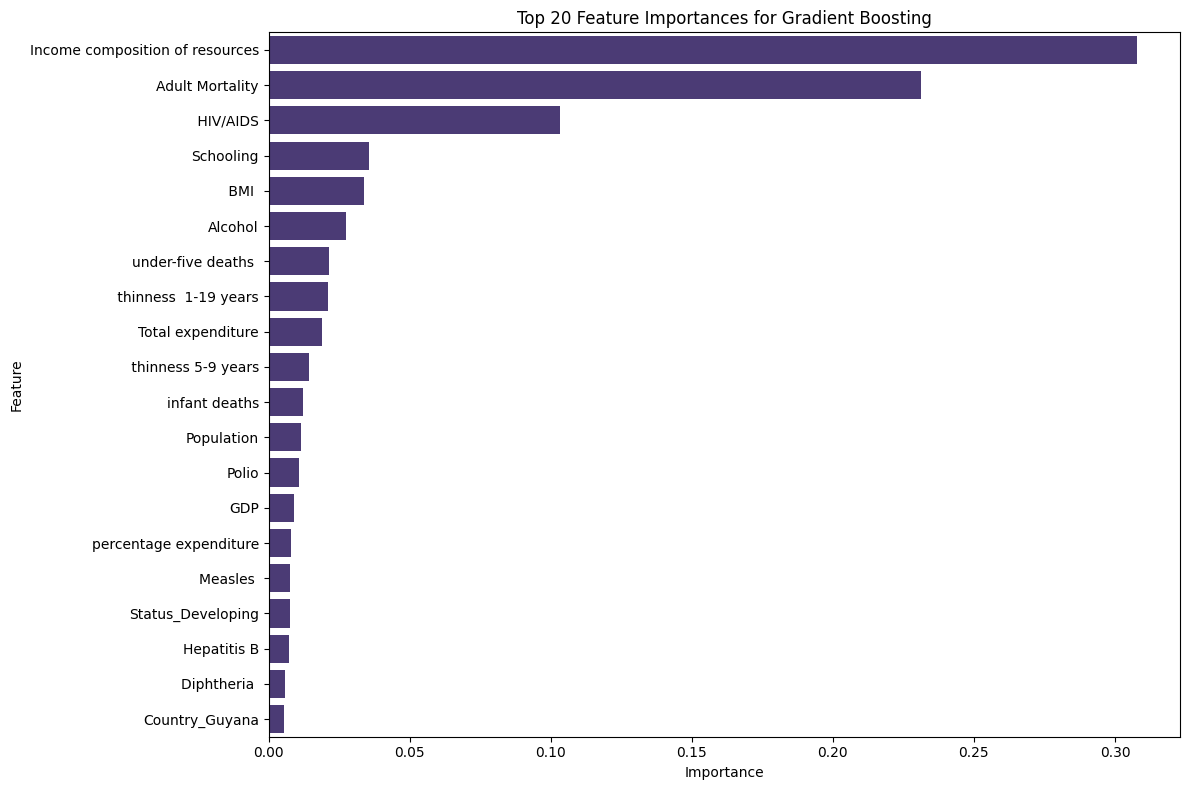

In [30]:
# Check if the best model has feature_importances_ attribute
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Create a DataFrame of feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("Top 20 important features:")
    print(feature_importance_df.head(20))
    
    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title(f'Top 20 Feature Importances for {best_model_name}')
    plt.tight_layout()
    plt.show()
elif best_model_name == 'Logistic Regression':
    # For Logistic Regression, we can use coefficients
    coefficients = best_model.coef_
    
    # For multi-class, we have coefficients for each class
    for i, class_coef in enumerate(coefficients):
        # Create a DataFrame of coefficients
        coef_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': np.abs(class_coef)  # Use absolute values for importance
        })
        
        # Sort by coefficient magnitude
        coef_df = coef_df.sort_values('Coefficient', ascending=False)
        
        # Display top 10 features for this class
        print(f"\nTop 10 important features for Class {i} ({class_mapping[i]}):")
        print(coef_df.head(10))
        
        # Visualize coefficients
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10))
        plt.title(f'Top 10 Feature Importances for Class {class_mapping[i]}')
        plt.tight_layout()
        plt.show()
else:
    print(f"Feature importance analysis not available for {best_model_name}")

## Create a Simple Prediction Function

In [31]:
def predict_life_expectancy_class(model, scaler, data):
    """
    Predict life expectancy class using the trained model.
    
    Args:
        model: Trained classification model
        scaler: Fitted scaler
        data: DataFrame with features
        
    Returns:
        Predicted life expectancy class
    """
    # Scale the data
    scaled_data = scaler.transform(data)
    
    # Make prediction
    prediction = model.predict(scaled_data)
    
    # Map to class label
    class_label = class_mapping[prediction[0]]
    
    return class_label

In [44]:
# Test the prediction function with a sample from the test set
sample_data = X_test.iloc[[0]]
actual_class = class_mapping[y_test.iloc[0]]

predicted_class = predict_life_expectancy_class(best_model, scaler, sample_data)

print(f"Sample data:\n{sample_data}\n")
print(f"Actual life expectancy class: {actual_class}")
print(f"Predicted life expectancy class: {predicted_class}")

Sample data:
      Adult Mortality  infant deaths  Alcohol  percentage expenditure  \
1736            113.0              0     6.56              666.737437   

      Hepatitis B  Measles    BMI   under-five deaths   Polio  \
1736         91.0         5   59.7                   0   95.0   

      Total expenditure  Diphtheria    HIV/AIDS          GDP  Population  \
1736               6.92         95.0        0.1  7318.742449      6279.0   

       thinness  1-19 years   thinness 5-9 years  \
1736                    1.9                  2.0   

      Income composition of resources  Schooling  Status_Developing  \
1736                            0.792       15.1               True   

      Country_Albania  Country_Algeria  Country_Angola  \
1736            False            False           False   

      Country_Antigua and Barbuda  Country_Argentina  Country_Armenia  \
1736                        False              False            False   

      Country_Australia  Country_Austria  Co

## Summary and Conclusion

In this notebook, we've implemented classification models to predict life expectancy classes (Low, Medium, High) based on various health and socioeconomic factors. We've:

1. Converted the continuous life expectancy variable into three classes
2. Trained multiple classification models and evaluated their performance
3. Performed hyperparameter tuning for the top performing models
4. Identified the best classification model based on accuracy and F1 score
5. Analyzed feature importance to understand which factors most strongly influence life expectancy classification
6. Custom prediction function

## Best Model

The best performing model was Gradient Boosting, achieving an accuracy of 0.9388 and an F1 score of 0.9387. This model can effectively classify countries into low, medium, or high life expectancy categories based on their health and socioeconomic indicators.